In [2]:
#start with "cr" csv that contains count by date
#see IR forecast for original notes
import pandas as pd
import numpy as np

df = pd.read_csv("cr_total_ct.csv", header=0, index_col=0)
df.head()

,Count
Date,
1/1/19,109
1/2/19,476
1/3/19,522
1/4/19,592
1/5/19,171


In [3]:
df.shape

(821, 1)

In [4]:
#test to see of stationary

#p-value > 0.05: Fail to reject the null hypothesis (H0), 
#the data has a unit root and is non-stationary.

#p-value <= 0.05: Reject the null hypothesis (H0), 
#the data does not have a unit root and is stationary.

#stationary data in theory would have a "d" value of 0 in ARIMA(q,d,p)

from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(df.dropna())[1])

p-value: 0.20033139379758852


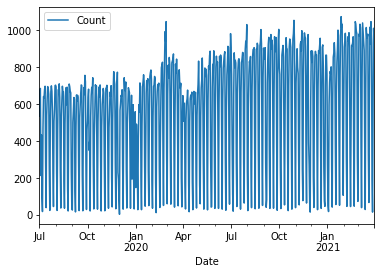

In [5]:
#reset index for plotting
explore = df.reset_index()

#change to date time for plotting
explore["Date"] = pd.to_datetime(explore["Date"])

#filter to dates wanted...why 7/1/19?...due to variance in May 2019?
explore = explore[(explore['Date'] >= '2019-07-01')]



#set date as index for plotting
explore.set_index('Date', inplace=True)

#plot to check for trends
from matplotlib import pyplot
explore.plot()
pyplot.show()

In [6]:
explore.shape

(640, 1)

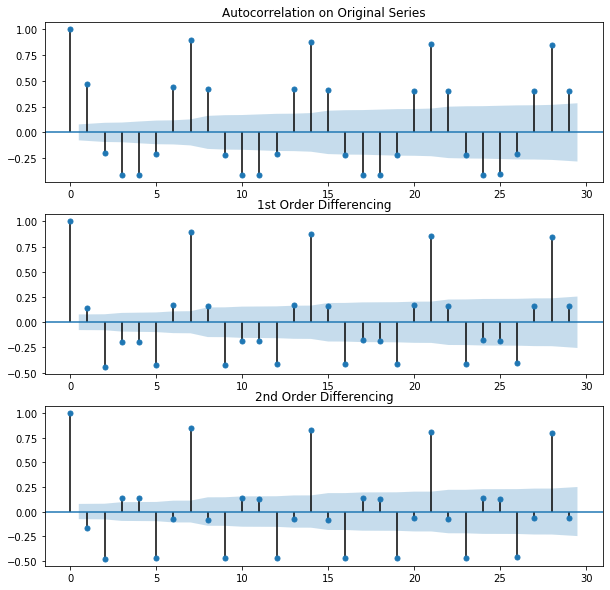

In [7]:
#find order of differencing (d parameter in arima(q, d, p))
#use ACF and PACf for autocorrelation

#need matplot lib
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(explore, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(explore.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(explore.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")
#d = 2

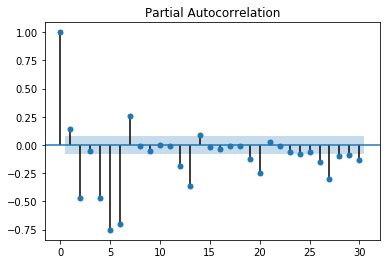

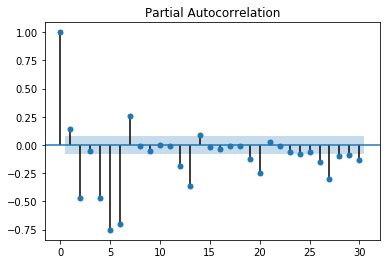

In [8]:
plot_pacf(explore.diff().dropna(), lags=30)
#how many points above level of significance? = p parameter = 5...clear 
#signficance to 5 lags(outside blue zone) then smaller pattern repeats
#try 7 for 7 day cycle

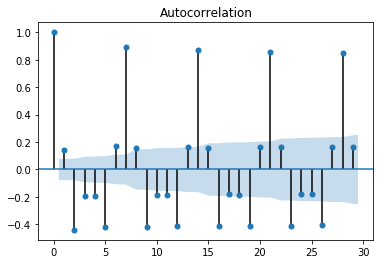

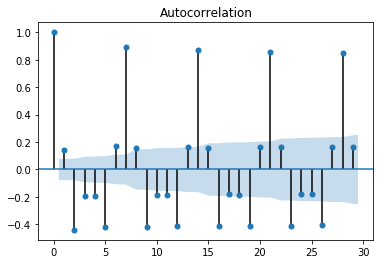

In [9]:
plot_acf(explore.diff().dropna())
#count number above significance level: q = 7...high points every 7 lags, 7 day cycle

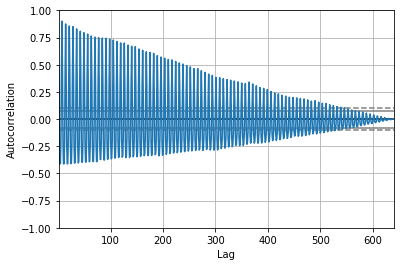

In [10]:
#auto_corrlation() function #& limit to 50 observations optional
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(explore)
#ax.set_xlim([0,50])
pyplot.show()

/Users/martinkunz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/martinkunz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/martinkunz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Count   No. Observations:                  639
Model:                 ARIMA(4, 1, 7)   Log Likelihood               -3866.025
Method:                       css-mle   S.D. of innovations            101.237
Date:                Wed, 21 Apr 2021   AIC                           7758.050
Time:                        12:42:24   BIC                           7816.029
Sample:                    07-02-2019   HQIC                          7780.556
                         - 03-31-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3962      0.335      1.182      0.237      -0.261       1.053
ar.L1.D.Count     0.8020      0.001    690.011      0.000       0.800       0.804
ar.L2.D.Count    -1.4447      0.001  -12

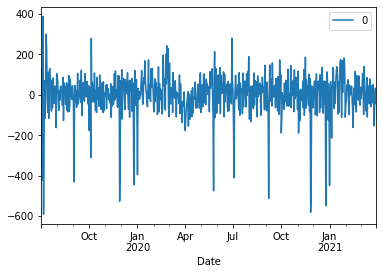

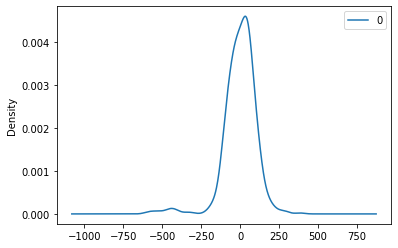

                0
count  639.000000
mean    -0.113170
std    106.446191
min   -591.623193
25%    -49.232839
50%      9.595994
75%     60.625429
max    385.125313


In [12]:
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

#cast ir_count to float
explore['Count']= explore['Count'].astype(np.float64)

# fit model
model = ARIMA(explore, order=(4,1,7))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

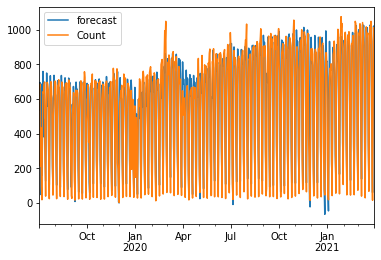

In [13]:
model_fit.plot_predict(dynamic=False)
plt.show()

## Out of time cross validation...look for prediction to be in grey zone (95% confidence), with actual (orange line) to be neither above or below green line consistently
#### https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [14]:
explore.shape

(640, 1)

In [15]:
cv = explore
cv.reset_index(inplace = True) 
cv = explore.Count
cv.head()

0    536.0
1    663.0
2    686.0
3    214.0
4    434.0
Name: Count, dtype: float64

In [16]:
cv.shape

(640,)

# change train, test (read notes), and days predicted

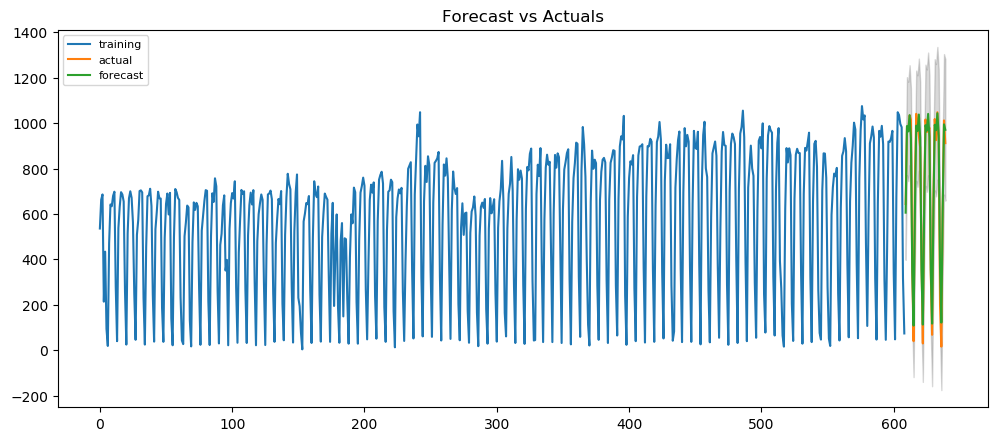

In [18]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
#change index value to cv.shape number - number days prior month
train = cv[:609]
test = cv[609:]

# Build Model

model1 = ARIMA(train, order=(4, 1, 5))  
fitted1 = model1.fit(disp=-1)  

# Forecast set to prior month days
fc, se, conf = fitted1.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## auto_arima method...change "d" parameter to check for lower AIC/BIC

In [20]:

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(cv, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=8979.539, BIC=8997.378, Fit time=0.216 seconds
Fit ARIMA: order=(0, 1, 0); AIC=9179.923, BIC=9188.843, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=9169.440, BIC=9182.820, Fit time=0.046 seconds
Fit ARIMA: order=(0, 1, 1); AIC=9124.472, BIC=9137.851, Fit time=0.023 seconds
Fit ARIMA: order=(2, 1, 1); AIC=8716.785, BIC=8739.084, Fit time=0.340 seconds
Fit ARIMA: order=(2, 1, 0); AIC=9012.881, BIC=9030.720, Fit time=0.058 seconds
Fit ARIMA: order=(2, 1, 2); AIC=8621.588, BIC=8648.347, Fit time=0.276 seconds
Fit ARIMA: order=(3, 1, 3); AIC=8584.757, BIC=8620.437, Fit time=0.448 seconds
Fit ARIMA: order=(2, 1, 3); AIC=8623.210, BIC=8654.429, Fit time=0.374 seconds
Fit ARIMA: order=(4, 1, 3); AIC=8110.180, BIC=8150.319, Fit time=2.115 seconds
Fit ARIMA: order=(4, 1, 2); AIC=8187.691, BIC=8223.370, Fit time=1.538 seconds
Fit ARIMA: order=(4, 1, 4); AIC=7998.241, BIC=8042.841, Fit time=2.652 seconds
Fit ARIMA: order=(5, 1, 5); AIC=7780.753, BIC=7834.2

/Users/martinkunz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/martinkunz/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/martinkunz/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/martinkunz/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## Create model

In [21]:
explore.head(2)

,Date,Count
0,2019-07-01,536.0
1,2019-07-02,663.0


predicted=852.722959, expected=941.000000
predicted=995.667115, expected=1005.000000
predicted=919.714005, expected=929.000000
predicted=332.978215, expected=344.000000
predicted=126.093246, expected=52.000000
predicted=604.147876, expected=746.000000
predicted=961.802173, expected=905.000000
predicted=887.384996, expected=846.000000
predicted=995.745956, expected=847.000000
predicted=874.549166, expected=907.000000
predicted=310.532790, expected=285.000000
predicted=121.549556, expected=42.000000
predicted=612.392766, expected=83.000000
predicted=762.861630, expected=716.000000
predicted=717.394116, expected=841.000000
predicted=922.134234, expected=926.000000
predicted=881.792200, expected=963.000000
predicted=290.068658, expected=360.000000
predicted=10.982437, expected=36.000000
predicted=465.534312, expected=695.000000
predicted=853.788598, expected=978.000000
predicted=845.806494, expected=898.000000
predicted=1008.852559, expected=948.000000
predicted=943.738321, expected=918.00

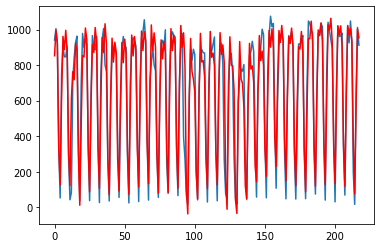

In [23]:
# alot of warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
 
X = explore['Count'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4, 1, 5))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Forecast

In [24]:
forecast = model_fit.forecast(steps=30)[0]

In [25]:
sum(forecast)/len(forecast)

715.8379014873765

In [26]:
total = sum(forecast)
print(total)

21475.137044621293


In [ ]:
# no longer needed
#def add_tail(tail):
#    total = 0
#    for row in tail:
#        total += row
#    return total

#total = add_tail(df['Review_Ct'].tail(8))
#actual_avg = total/8
#print(actual_avg)

In [ ]:
print(sum(forecast))